In [6]:
import pandas as pd
import numpy as np
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool, cv

Данные были с парсены с разных TG-каналов (2024 г, искал вакансии на русском, на территории РФ и с уровнем з/п). Собранный перечень вакансий был "пропущен" через локальную модель оллама, так как структура вакансий разнообразная. К вакансия были составлены промпты по выявлению: должности, локации, формата работы, типа занятости, скилов, требуемого опыта работы, уровня з/п.  
Предполагал, что оллама поможет структурировать сведения с вакансий и выделит какие-то сущности.  
Планирую: через AirFlow запускать парсинг ТГ-каналов, затем отправлять на LLM модель с промптами.  
Результат: почему-то иногда модель отвечала на аглийском, какие-то сущности выделила модель в отдельные предложения, поэтому бОльшая часть будет обрабатываться регуляркой. Считаю что, оллама немного систематизировала информацию и есть надежда, что регулярки строить будет немного проще.

In [117]:
df = pd.read_csv("./dataset_vac.csv", sep ="|")
df.head()

,job,location,location_2,type_schedule,shedul,type_busy,format_job,skills,experience,salary,descr_vac
0,"The job title in the given vacancy text is ""В...","The job vacancy specifies the region as ""Моск...",Место работы в данной вакансии — Москва (Моск...,На основании предоставленного текста вакансии...,В тексте вакансии не указано конкретное распи...,В данном объявлении о вакансии не указано кон...,"Для определения формата работы (remote, hybri...","Based on the provided job posting in Russian,...",В приведенном тексте вакансии не указано конк...,"В данном объявлении о вакансии указано, что з...",#вакансия #data #analyst #sql #sber #Москва Ко...
1,В данном тексте вакансии на русском языке ука...,The job vacancy does not specify a particular...,"В данном тексте вакансии указано, что формат ...","В данной вакансии указано, что формат работы ...",В данном тексте вакансии на русском языке ука...,"В данной вакансии указано, что формат работы ...","Based on the job listing text in Russian, the...","Based on the provided job posting in Russian,...",В данном объявлении о вакансии требуется комм...,"В тексте вакансии указано, что предлагаемая з...",#вакансия #удаленка #middle+ #са #системныйана...
2,В данной вакансии указаны две профессиональны...,Based on the job vacancy description provided...,В данном объявлении о вакансии место работы у...,The job posting in Russian indicates that the...,В объявлении о вакансии указано следующее рас...,В данном объявлении указаны два формата работ...,The job listing text is for a remote work for...,"Based on the provided job posting in Russian,...","В данной вакансии указано, что требуемый опыт...",The offered salary in the job posting text is...,#вакансия #middle #remote **Требуются ML-инжен...
3,"The job title in the vacancy text is ""Middle ...","The job vacancy mentions ""Локация: Россия,"" w...","Локация, указанная в данной вакансии, находит...",В данном объявлении о вакансии не указан конк...,В данном объявлении о вакансии не указан конк...,"На основании предоставленной информации, в да...","На основании текста вакансии, можно сделать в...",Основные требуемые навыки для вакансии Middle...,В данной вакансии не указан конкретный требуе...,В данном объявлении о вакансии предлагаемая з...,#вакансия #аналитикданных #SQL #AB #статистика...
4,Системный аналитик,"The job vacancy specifies the region as ""Крас...","Город работы указан как ""Краснодар"".","В job posting указано ""Занятость: полный день...","В данном объявлении о вакансии указано, что г...",В указанном вами объявлении о вакансии на рус...,Формат работы: офис\удаленка (гибридный),"На основе предоставленного текста, необходимы...",В тексте вакансии не указан конкретный опыт р...,В данном объявлении о вакансии указана следую...,#вакансия #Системныйаналитик #Бизнес_аналитик ...


In [118]:
df.drop_duplicates(inplace=True)
df.shape

(783, 11)

Далее выявляем уровень з/п в вакансии, также через регулярные выражения

In [119]:
df["salary_min_max"] = df["salary"].str.findall(
    r'(рублей|долларов|евро|руб|дол|евр|р|₽|\$|USD|€)?(\d+[\s\.,-]*\d+[\s\.,\d]*)\s*(рублей|долларов|евро|руб|дол|евр|р|₽|\$|USD|€)?',
    flags=re.I).apply(lambda x: list(set(x))  if not isinstance(x,(float,type(None))) and len(x)!=0 else np.NAN)
df["salary_min_max"].value_counts(), df["salary_min_max"].isnull().sum()

(salary_min_max
 [(, 250 000 , рублей)]                                               8
 [(, 300 000 , рублей)]                                               7
 [(, 200 , )]                                                         6
 [(, 400 , рублей), (, 6000 , рублей), (, 4000 , ), (, 300 , )]       5
 [(, 300 000 , рублей), (, 250 000 , )]                               5
                                                                     ..
 [(, 180 000 , ), (, 220 000 , рублей)]                               1
 [(, 4000 , ), (, 6000 , долларов)]                                   1
 [(, 280 , ), (, 340 , )]                                             1
 [(, 200,000 , ), (, 160,000 , ), (, 160 000 , ), (, 200 000 , ₽)]    1
 [(, 100 000 , ), (, 200 000 , ₽)]                                    1
 Name: count, Length: 533, dtype: int64,
 109)

Создаем из выявленых данных об уровне з/п две колонки: минимальная и максимальная з/п, указанная в вакансии

In [120]:
def func_salary(s):
    if not isinstance(s,(float,type(None))):
        s_min, s_max = s[0], s[-1]
        if len(re.findall("-", s_min[1]+s_max[1])):
            if s_min[1]==s_max[1]:
                s_min_new, s_max_new = s_min[1].split("-")
                s_min_new, s_max_new  = int(re.sub(r"\D*","",s_min_new)), int(re.sub(r"\D*","",s_max_new))
                for val in ["долларов","евро","дол","евр","$","USD","€"]:
                    if val in set(s_min+s_max):
                        s_min_new*=100
                        s_max_new*=100
                        break
            else:
                for t in s:
                    if len(re.findall("-", "".join(t))):
                        s_min_new, s_max_new = t[1].split("-")
                        s_min_new, s_max_new  = int(re.sub(r"\D*","",s_min_new)), int(re.sub(r"\D*","",s_max_new))
                        for val in ["долларов","евро","дол","евр","$","USD","€"]:
                            if val in set(t):
                                s_min_new*=100
                                s_max_new*=100
                                break
                        #print("min<>max",s,">>>>",s_min_new,s_max_new)
        else:
            if re.sub(r"\D*","",s_min[1])==re.sub(r"\D*","",s_max[1]):
                s_min_new = 0
                s_max_new = int(re.sub(r"\D*","",s_max[1]))
                for val in ["долларов","евро","дол","евр","$","USD","€"]:
                    if val in set(s_min+s_max):
                        s_min_new*=100
                        s_max_new*=100
                        break
            elif int(re.sub(r"\D*","",s_min[1]))<int(re.sub(r"\D*","",s_max[1])):
                s_min_new = int(re.sub(r"\D*","",s_min[1]))
                s_max_new = int(re.sub(r"\D*","",s_max[1]))
                for val in ["долларов","евро","дол","евр","$","USD","€"]:
                    if val in set(s_min+s_max):
                        s_min_new*=100
                        s_max_new*=100
                        break
            elif int(re.sub(r"\D*","",s_min[1]))>int(re.sub(r"\D*","",s_max[1])):
                s_max_new = int(re.sub(r"\D*","",s_min[1]))
                s_min_new = int(re.sub(r"\D*","",s_max[1]))
                for val in ["долларов","евро","дол","евр","$","USD","€"]:
                    if val in set(s_min+s_max):
                        s_min_new*=100
                        s_max_new*=100
                        break

        if s_min_new<s_max_new<900:
            s_min_new*=1000
            s_max_new*=1000
        #print(s_min_new,s_max_new, s)
        if s_max_new<s_min_new:
            print("EGCCC", s_min_new,s_max_new, s)
        return (s_min_new,s_max_new)
                    

df["salary_min_max"].apply(lambda salary : func_salary(salary))
df["salary_min"] = df["salary_min_max"].map(lambda salary : func_salary(salary)[0] if not isinstance(salary,(float,type(None))) else np.NAN)
df["salary_max"] = df["salary_min_max"].map(lambda salary : func_salary(salary)[-1] if not isinstance(salary,(float,type(None))) else np.NAN)
df["salary_mean"] = (df["salary_max"] + df["salary_min"])/2

df.head()

,job,location,location_2,type_schedule,shedul,type_busy,format_job,skills,experience,salary,descr_vac,salary_min_max,salary_min,salary_max,salary_mean
0,"The job title in the given vacancy text is ""В...","The job vacancy specifies the region as ""Моск...",Место работы в данной вакансии — Москва (Моск...,На основании предоставленного текста вакансии...,В тексте вакансии не указано конкретное распи...,В данном объявлении о вакансии не указано кон...,"Для определения формата работы (remote, hybri...","Based on the provided job posting in Russian,...",В приведенном тексте вакансии не указано конк...,"В данном объявлении о вакансии указано, что з...",#вакансия #data #analyst #sql #sber #Москва Ко...,NaN,NaN,NaN,NaN
1,В данном тексте вакансии на русском языке ука...,The job vacancy does not specify a particular...,"В данном тексте вакансии указано, что формат ...","В данной вакансии указано, что формат работы ...",В данном тексте вакансии на русском языке ука...,"В данной вакансии указано, что формат работы ...","Based on the job listing text in Russian, the...","Based on the provided job posting in Russian,...",В данном объявлении о вакансии требуется комм...,"В тексте вакансии указано, что предлагаемая з...",#вакансия #удаленка #middle+ #са #системныйана...,"[(, 160 , )]",0.0,160000.0,80000.0
2,В данной вакансии указаны две профессиональны...,Based on the job vacancy description provided...,В данном объявлении о вакансии место работы у...,The job posting in Russian indicates that the...,В объявлении о вакансии указано следующее рас...,В данном объявлении указаны два формата работ...,The job listing text is for a remote work for...,"Based on the provided job posting in Russian,...","В данной вакансии указано, что требуемый опыт...",The offered salary in the job posting text is...,#вакансия #middle #remote **Требуются ML-инжен...,"[(, 150,000 , ), (, 230,000 , )]",150000.0,230000.0,190000.0
3,"The job title in the vacancy text is ""Middle ...","The job vacancy mentions ""Локация: Россия,"" w...","Локация, указанная в данной вакансии, находит...",В данном объявлении о вакансии не указан конк...,В данном объявлении о вакансии не указан конк...,"На основании предоставленной информации, в да...","На основании текста вакансии, можно сделать в...",Основные требуемые навыки для вакансии Middle...,В данной вакансии не указан конкретный требуе...,В данном объявлении о вакансии предлагаемая з...,#вакансия #аналитикданных #SQL #AB #статистика...,"[(, 240-270, ), (, 240-270 , )]",240000.0,270000.0,255000.0
4,Системный аналитик,"The job vacancy specifies the region as ""Крас...","Город работы указан как ""Краснодар"".","В job posting указано ""Занятость: полный день...","В данном объявлении о вакансии указано, что г...",В указанном вами объявлении о вакансии на рус...,Формат работы: офис\удаленка (гибридный),"На основе предоставленного текста, необходимы...",В тексте вакансии не указан конкретный опыт р...,В данном объявлении о вакансии указана следую...,#вакансия #Системныйаналитик #Бизнес_аналитик ...,"[(, 200 000 , руб), (, 150 000 , )]",150000.0,200000.0,175000.0


Удаляем в датасете вакансии без з/п

In [121]:
df = df[~df["salary_min_max"].isnull()]
df.head()

,job,location,location_2,type_schedule,shedul,type_busy,format_job,skills,experience,salary,descr_vac,salary_min_max,salary_min,salary_max,salary_mean
1,В данном тексте вакансии на русском языке ука...,The job vacancy does not specify a particular...,"В данном тексте вакансии указано, что формат ...","В данной вакансии указано, что формат работы ...",В данном тексте вакансии на русском языке ука...,"В данной вакансии указано, что формат работы ...","Based on the job listing text in Russian, the...","Based on the provided job posting in Russian,...",В данном объявлении о вакансии требуется комм...,"В тексте вакансии указано, что предлагаемая з...",#вакансия #удаленка #middle+ #са #системныйана...,"[(, 160 , )]",0.0,160000.0,80000.0
2,В данной вакансии указаны две профессиональны...,Based on the job vacancy description provided...,В данном объявлении о вакансии место работы у...,The job posting in Russian indicates that the...,В объявлении о вакансии указано следующее рас...,В данном объявлении указаны два формата работ...,The job listing text is for a remote work for...,"Based on the provided job posting in Russian,...","В данной вакансии указано, что требуемый опыт...",The offered salary in the job posting text is...,#вакансия #middle #remote **Требуются ML-инжен...,"[(, 150,000 , ), (, 230,000 , )]",150000.0,230000.0,190000.0
3,"The job title in the vacancy text is ""Middle ...","The job vacancy mentions ""Локация: Россия,"" w...","Локация, указанная в данной вакансии, находит...",В данном объявлении о вакансии не указан конк...,В данном объявлении о вакансии не указан конк...,"На основании предоставленной информации, в да...","На основании текста вакансии, можно сделать в...",Основные требуемые навыки для вакансии Middle...,В данной вакансии не указан конкретный требуе...,В данном объявлении о вакансии предлагаемая з...,#вакансия #аналитикданных #SQL #AB #статистика...,"[(, 240-270, ), (, 240-270 , )]",240000.0,270000.0,255000.0
4,Системный аналитик,"The job vacancy specifies the region as ""Крас...","Город работы указан как ""Краснодар"".","В job posting указано ""Занятость: полный день...","В данном объявлении о вакансии указано, что г...",В указанном вами объявлении о вакансии на рус...,Формат работы: офис\удаленка (гибридный),"На основе предоставленного текста, необходимы...",В тексте вакансии не указан конкретный опыт р...,В данном объявлении о вакансии указана следую...,#вакансия #Системныйаналитик #Бизнес_аналитик ...,"[(, 200 000 , руб), (, 150 000 , )]",150000.0,200000.0,175000.0
5,The job title in the provided vacancy text is...,The job vacancy you provided does not explici...,В данном объявлении о вакансии место работы у...,"The job posting indicates a ""Full-time"" work ...",В данной вакансии указано следующее расписани...,На основании предоставленного текста job list...,The job listing text in Russian matches the *...,Основные требования к кандидату: - Уверенное ...,В данном объявлении о вакансии требуется след...,В данном объявлении о вакансии предлагается з...,#вакансия #инженер #engineer #DataEngineer #mi...,"[(, 250 000 , рублей)]",0.0,250000.0,125000.0


Переносим данные с колонки с максимальной з/п в колонку с минимальной на место нулевых значений. планирую прогнозировать минимальный уровень или среднее значение з/п

In [122]:
df['salary_min'] = df.apply(
    lambda row: row['salary_max'] if row['salary_min']==0 else row['salary_min'],
    axis=1)
df['salary_max'] = df.apply(
    lambda row: 0 if row['salary_min']==row['salary_max'] else row['salary_max'],
    axis=1)

In [123]:
df.head()

,job,location,location_2,type_schedule,shedul,type_busy,format_job,skills,experience,salary,descr_vac,salary_min_max,salary_min,salary_max,salary_mean
1,В данном тексте вакансии на русском языке ука...,The job vacancy does not specify a particular...,"В данном тексте вакансии указано, что формат ...","В данной вакансии указано, что формат работы ...",В данном тексте вакансии на русском языке ука...,"В данной вакансии указано, что формат работы ...","Based on the job listing text in Russian, the...","Based on the provided job posting in Russian,...",В данном объявлении о вакансии требуется комм...,"В тексте вакансии указано, что предлагаемая з...",#вакансия #удаленка #middle+ #са #системныйана...,"[(, 160 , )]",160000.0,0.0,80000.0
2,В данной вакансии указаны две профессиональны...,Based on the job vacancy description provided...,В данном объявлении о вакансии место работы у...,The job posting in Russian indicates that the...,В объявлении о вакансии указано следующее рас...,В данном объявлении указаны два формата работ...,The job listing text is for a remote work for...,"Based on the provided job posting in Russian,...","В данной вакансии указано, что требуемый опыт...",The offered salary in the job posting text is...,#вакансия #middle #remote **Требуются ML-инжен...,"[(, 150,000 , ), (, 230,000 , )]",150000.0,230000.0,190000.0
3,"The job title in the vacancy text is ""Middle ...","The job vacancy mentions ""Локация: Россия,"" w...","Локация, указанная в данной вакансии, находит...",В данном объявлении о вакансии не указан конк...,В данном объявлении о вакансии не указан конк...,"На основании предоставленной информации, в да...","На основании текста вакансии, можно сделать в...",Основные требуемые навыки для вакансии Middle...,В данной вакансии не указан конкретный требуе...,В данном объявлении о вакансии предлагаемая з...,#вакансия #аналитикданных #SQL #AB #статистика...,"[(, 240-270, ), (, 240-270 , )]",240000.0,270000.0,255000.0
4,Системный аналитик,"The job vacancy specifies the region as ""Крас...","Город работы указан как ""Краснодар"".","В job posting указано ""Занятость: полный день...","В данном объявлении о вакансии указано, что г...",В указанном вами объявлении о вакансии на рус...,Формат работы: офис\удаленка (гибридный),"На основе предоставленного текста, необходимы...",В тексте вакансии не указан конкретный опыт р...,В данном объявлении о вакансии указана следую...,#вакансия #Системныйаналитик #Бизнес_аналитик ...,"[(, 200 000 , руб), (, 150 000 , )]",150000.0,200000.0,175000.0
5,The job title in the provided vacancy text is...,The job vacancy you provided does not explici...,В данном объявлении о вакансии место работы у...,"The job posting indicates a ""Full-time"" work ...",В данной вакансии указано следующее расписани...,На основании предоставленного текста job list...,The job listing text in Russian matches the *...,Основные требования к кандидату: - Уверенное ...,В данном объявлении о вакансии требуется след...,В данном объявлении о вакансии предлагается з...,#вакансия #инженер #engineer #DataEngineer #mi...,"[(, 250 000 , рублей)]",250000.0,0.0,125000.0


Из собранных с кеглла датасетов с вакансиями по DS, выбрал названия должностей. Далее я их использую для извлечения из своего датасета названия должностей.  
Планировал: кластиризовать названия должностей.

In [124]:
df_ds_vac = pd.read_csv("./raw_dataset/Kaggle_dataset/ds_salaries.csv", sep=",")
df_ds_vac.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [125]:
list_job_ds_eng = df_ds_vac.job_title.str.lower().unique()
list_job_ds_eng.shape

(93,)

Имеющейся список из 93 вакансий на английском языке (в имеющихся названиях должности состоят только из буквенных символов, а в моих некоторых названиях содержатся:"-") использую для извлечения из моего датасета название должностей.

Создаю регулярку из английских вакансий и далее применяю для извлечения должностей из моего датасета

In [126]:
list_job_ds_eng_re = ["[\s-]".join(job.split()) for job in list_job_ds_eng]
reg_vac_eng = "|".join(list_job_ds_eng_re)
print(reg_vac_eng)

principal[\s-]data[\s-]scientist|ml[\s-]engineer|data[\s-]scientist|applied[\s-]scientist|data[\s-]analyst|data[\s-]modeler|research[\s-]engineer|analytics[\s-]engineer|business[\s-]intelligence[\s-]engineer|machine[\s-]learning[\s-]engineer|data[\s-]strategist|data[\s-]engineer|computer[\s-]vision[\s-]engineer|data[\s-]quality[\s-]analyst|compliance[\s-]data[\s-]analyst|data[\s-]architect|applied[\s-]machine[\s-]learning[\s-]engineer|ai[\s-]developer|research[\s-]scientist|data[\s-]analytics[\s-]manager|business[\s-]data[\s-]analyst|applied[\s-]data[\s-]scientist|staff[\s-]data[\s-]analyst|etl[\s-]engineer|data[\s-]devops[\s-]engineer|head[\s-]of[\s-]data|data[\s-]science[\s-]manager|data[\s-]manager|machine[\s-]learning[\s-]researcher|big[\s-]data[\s-]engineer|data[\s-]specialist|lead[\s-]data[\s-]analyst|bi[\s-]data[\s-]engineer|director[\s-]of[\s-]data[\s-]science|machine[\s-]learning[\s-]scientist|mlops[\s-]engineer|ai[\s-]scientist|autonomous[\s-]vehicle[\s-]technician|applied[\s

Создаем первый столбец извлеченных должностей, применяя первый подход (регулярку из английских вакансий)

In [127]:
df_job_1 = df["job"].str.findall(reg_vac_eng, flags=re.I).apply(lambda x : ";".join(x) if len(x)>0 else np.nan)
df_job_1.isnull().sum(), df_job_1.head()

(381,
 1               NaN
 2    Data Scientist
 3      Data Analyst
 4               NaN
 5     Data Engineer
 Name: job, dtype: object)

Продолжаем строить регулярки, так как после первой - у нас еще 381 вакансия остается для последующей обработки 

создаем 2-ю регулярку по извлечению названий должностей. В тексте вакансий некоторые должности заключены в кавычки и звездочки (это оставленный артефакт после парсинга TG, админы выделяли жирный **текст**)

In [128]:
df_job_2 = df["job"].str.extract(
    r'(?:")([^"]+)(?:")|(?:\*)([^*]+)(?:\*)',
    flags=re.I).apply(lambda job: job.str.lower())
df_job_2.head()

,0,1
1,NaN,системный аналитик
2,NaN,ml-инженеры
3,middle дата аналитик,NaN
4,NaN,NaN
5,data engineer,NaN


Необходимо объеденить выявленные должности. Приоритет: сначало дополняем 1 столбец недостающими значениями из 2, затем из 3 и т.д.

In [129]:
temp_df_job = pd.merge(df_job_1,df_job_2, left_index=True, right_index=True)
temp_df_job.isnull().sum()

job    381
0      342
1      405
dtype: int64

Сводим все выявленные названия должностей в один столбец

In [130]:
temp_df_job['job'] = temp_df_job.apply(
    lambda row: row[0] if pd.isnull(row['job']) else row['job'],
    axis=1
)
temp_df_job['job'] = temp_df_job.apply(
    lambda row: row[1] if pd.isnull(row['job']) else row['job'],
    axis=1
)
temp_df_job.head(),
temp_df_job.job.isnull().sum()

50

Осталось извлечь название должностей из оставшихся вакансий (50 вакансии).  
Проведем анализ название оставшихся вакансий для создания очередной регулярки

In [131]:
df.job[temp_df_job.job.isnull()]

4                                     Системный аналитик
15                          Ведущий аналитик-разработчик
22                        Позиция: ML + Java разработчик
47      Должность: Руководитель направления по исслед...
53                                  Вакансия: ML инженер
77      Позиция: Руководитель группы продуктовой и ма...
78      Позиция: Руководитель группы продуктовой и ма...
95                                Ведущий разработчик 1С
97                 Вакансия: SQL - аналитик (PostgreSQL)
99                 Вакансия: SQL - аналитик (PostgreSQL)
120     Название вакансии: Junior или Middle PHP разр...
148     Название вакансии: Вакансия для начинающих Da...
150                         Вакансия: Системный аналитик
183     Должность: Руководитель направления по исслед...
188                               Вакансия: Web-аналитик
203             Должность: Руководитель продуктового P&L
226                      Должность: Продуктовый аналитик
242     Должность в данной вака

Создаем третью регулярку по извлечению названия должности из вакансии, так же есть уже отчищенные значения 

In [132]:
df_job_3 = df.job[temp_df_job.job.isnull()].str.extract(
    r'(?::)([^:]+)(?:$)',
    flags=re.I).apply(lambda job: job.str.lower())
df_job_3.head()

,0
4,NaN
15,NaN
22,ml + java разработчик
47,руководитель направления по исследованию данных
53,ml инженер


In [133]:
temp_df_job= pd.merge(temp_df_job,df_job_3, left_index=True, right_index=True, how="left")
temp_df_job['job'] = temp_df_job.apply(
    lambda row: row["0_y"] if pd.isnull(row['job']) else row['job'],
    axis=1
)
temp_df_job.job.head()

1    системный аналитик
2        Data Scientist
3          Data Analyst
4                   NaN
5         Data Engineer
Name: job, dtype: object

In [134]:
df_job_4 = df.job[temp_df_job.job.isnull()].str.extract(
    r'([\w\s]+)',
    flags=re.I).apply(lambda job: job.str.lower())
df_job_4.head(10)

,0
4,системный аналитик
15,ведущий аналитик
95,ведущий разработчик 1с
435,middle researcher
578,middle product analyst
598,ml инженер
685,senior dl engineer
715,стажер продуктовый аналитик


Сводим все колонки с выявленными должностями в одну

In [136]:
temp_df_job= pd.merge(temp_df_job,df_job_4, left_index=True, right_index=True, how="left")
temp_df_job

,job,0_x,1,0_y,0
1,системный аналитик,NaN,системный аналитик,NaN,NaN
2,Data Scientist,NaN,ml-инженеры,NaN,NaN
3,Data Analyst,middle дата аналитик,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,системный аналитик
5,Data Engineer,data engineer,NaN,NaN,NaN
...,...,...,...,...,...
777,аналитик dwh (senior),аналитик dwh (senior),NaN,NaN,NaN
779,Data Engineer,NaN,позиция,NaN,NaN
780,аналитик цифрового маркетинга / digital market...,NaN,аналитик цифрового маркетинга / digital market...,NaN,NaN
781,продуктовый аналитик,продуктовый аналитик,NaN,NaN,NaN


Проверяем, что все вакансии имеют название предлагаемой работы/должности

In [137]:
temp_df_job['job'] = temp_df_job.apply(
    lambda row: row[0] if pd.isnull(row['job']) else row['job'],
    axis=1
)
temp_df_job.job.isnull().sum()

0

Надо применить чистку вакансий для дальнейшей их группировки

In [138]:
df_new= pd.merge(df[["location","location_2","type_schedule","shedul","type_busy","format_job", "skills","experience","salary","salary_min","salary_max","salary_mean","descr_vac"]],
                  temp_df_job[['job']],
                  left_index=True, right_index=True, how="left")
df_new.head()

,location,location_2,type_schedule,shedul,type_busy,format_job,skills,experience,salary,salary_min,salary_max,salary_mean,descr_vac,job
1,The job vacancy does not specify a particular...,"В данном тексте вакансии указано, что формат ...","В данной вакансии указано, что формат работы ...",В данном тексте вакансии на русском языке ука...,"В данной вакансии указано, что формат работы ...","Based on the job listing text in Russian, the...","Based on the provided job posting in Russian,...",В данном объявлении о вакансии требуется комм...,"В тексте вакансии указано, что предлагаемая з...",160000.0,0.0,80000.0,#вакансия #удаленка #middle+ #са #системныйана...,системный аналитик
2,Based on the job vacancy description provided...,В данном объявлении о вакансии место работы у...,The job posting in Russian indicates that the...,В объявлении о вакансии указано следующее рас...,В данном объявлении указаны два формата работ...,The job listing text is for a remote work for...,"Based on the provided job posting in Russian,...","В данной вакансии указано, что требуемый опыт...",The offered salary in the job posting text is...,150000.0,230000.0,190000.0,#вакансия #middle #remote **Требуются ML-инжен...,Data Scientist
3,"The job vacancy mentions ""Локация: Россия,"" w...","Локация, указанная в данной вакансии, находит...",В данном объявлении о вакансии не указан конк...,В данном объявлении о вакансии не указан конк...,"На основании предоставленной информации, в да...","На основании текста вакансии, можно сделать в...",Основные требуемые навыки для вакансии Middle...,В данной вакансии не указан конкретный требуе...,В данном объявлении о вакансии предлагаемая з...,240000.0,270000.0,255000.0,#вакансия #аналитикданных #SQL #AB #статистика...,Data Analyst
4,"The job vacancy specifies the region as ""Крас...","Город работы указан как ""Краснодар"".","В job posting указано ""Занятость: полный день...","В данном объявлении о вакансии указано, что г...",В указанном вами объявлении о вакансии на рус...,Формат работы: офис\удаленка (гибридный),"На основе предоставленного текста, необходимы...",В тексте вакансии не указан конкретный опыт р...,В данном объявлении о вакансии указана следую...,150000.0,200000.0,175000.0,#вакансия #Системныйаналитик #Бизнес_аналитик ...,системный аналитик
5,The job vacancy you provided does not explici...,В данном объявлении о вакансии место работы у...,"The job posting indicates a ""Full-time"" work ...",В данной вакансии указано следующее расписани...,На основании предоставленного текста job list...,The job listing text in Russian matches the *...,Основные требования к кандидату: - Уверенное ...,В данном объявлении о вакансии требуется след...,В данном объявлении о вакансии предлагается з...,250000.0,0.0,125000.0,#вакансия #инженер #engineer #DataEngineer #mi...,Data Engineer


In [139]:
df_new.job.unique(), df_new.job.nunique()

(array(['системный аналитик', 'Data Scientist', 'Data Analyst',
        ' системный аналитик', 'Data Engineer',
        'cv / ml / dl инженер (стажер / джун)', 'ML Engineer',
        'преподаватель онлайн-курса reinforcement learning.', 'BI Analyst',
        'Machine Learning Engineer', 'Data Engineer;Data Architect',
        ' ведущий аналитик',
        'преподаватель онлайн-курса [reinforcement learning](https://otus.ru/lessons/reinforcement-learning-cours/)',
        'NLP engineer', 'ML engineer', '"системный аналитик"',
        'преподаватель онлайн-курсов', ' ml + java разработчик',
        'разработчик greenplum', 'techlead/cto', 'Deep Learning Engineer',
        'python-разработчик (computer vision)', 'bi-аналитик',
        'системный аналитик/system analyst middle+',
        '"системный аналитик/system analyst middle+"',
        'ml-инженер/разработчик', 'Lead Data Engineer',
        'преподаватель онлайн-курса «clickhouse для инженеров и архитекторов бд»',
        'аналитик да

Продолжаю "чистить" выявленные названия должностей в надежде их сгруппировать.

In [140]:
df_new.job = df_new.job.str.lower()
df_new.job = df_new.job.str.replace("(\()[^()]+(\))", '', regex=True)
df_new.job = df_new.job.str.replace("(\,)[^()]+($)", '', regex=True)
df_new.job  = df_new.job.str.replace("(\[)[^()]+(\])", '', regex=True)
df_new.job.nunique()

300

In [141]:
df_new.job.unique()

array(['системный аналитик', 'data scientist', 'data analyst',
       ' системный аналитик', 'data engineer', 'cv / ml / dl инженер ',
       'ml engineer',
       'преподаватель онлайн-курса reinforcement learning.', 'bi analyst',
       'machine learning engineer', 'data engineer;data architect',
       ' ведущий аналитик', 'преподаватель онлайн-курса ', 'nlp engineer',
       '"системный аналитик"', 'преподаватель онлайн-курсов',
       ' ml + java разработчик', 'разработчик greenplum', 'techlead/cto',
       'deep learning engineer', 'python-разработчик ', 'bi-аналитик',
       'системный аналитик/system analyst middle+',
       '"системный аналитик/system analyst middle+"',
       'ml-инженер/разработчик', 'lead data engineer',
       'преподаватель онлайн-курса «clickhouse для инженеров и архитекторов бд»',
       'аналитик данных ', '"аналитик данных" ',
       ' руководитель направления по исследованию данных',
       '"data science-специалист"', 'аналитик данных', ' ml инженер

Определяем кваллификацию указанную в вакансиях:  
- поиск по ключевым словам intern|Junior|Middle|Senior|Руководитель|Lead|Team Lead|Стажер|мидл|сеньор|джун  
- поиск по годам: менее 2 лет - Junior, от 2 до 4 - Middle, от 5 и более - Senior

In [142]:
df_qual_1 = df_new["job"].str.extract(
    r'(?P<qual_1>Стажер|мидл|сеньор|джун|intern|jr|Junior|Middle|Senior|Руководитель|Lead)',
    flags=re.I, expand=True).apply(lambda ql: ql.str.lower().str.strip())
df_qual_1.isnull().sum()

qual_1    568
dtype: int64

In [28]:
df_qual_2 = df_new["descr_vac"].str.extract(
    r'(?P<qual_2>Стажер|мидл|сеньор|джун|intern|jr|Junior|Middle|Senior|Руководитель|Lead)',
    flags=re.I, expand=True).apply(lambda ql: ql.str.lower().str.strip())
df_qual_2.isnull().sum()

qual_2    272
dtype: int64

In [143]:
temp_df_qual = pd.merge(df_qual_2,df_qual_1, left_index=True, right_index=True)
temp_df_qual.head()

,qual_2,qual_1
1,middle,NaN
2,middle,NaN
3,middle,NaN
4,middle,NaN
5,middle,NaN


Осталось 271 вакансия без уровня квалификации. Далее рассматриваю определение квалификации через указанный в вакансиях требуемый опыт

In [144]:
temp_df_qual['qual'] = temp_df_qual.apply(
    lambda row: row["qual_1"] if pd.isnull(row['qual_2']) else row['qual_2'],
    axis=1
)
temp_df_qual['qual'].isnull().sum()

271

Далее уровень квалификации определяем по указанному в вакансии опыту работы 

In [145]:
df_experience= df_new["experience"].str.findall(
    r'\b(\d{1,2})[\s]*(лет|год|года|г|л)\b',
    flags=re.I).apply(lambda x: list(set(x)) if not isinstance(x,(float,type(None))) and len(x)!=0 else np.NAN)
df_experience.isnull().sum(), df_experience.value_counts()

(368,
 experience
 [(3, лет)]                                              74
 [(2, лет)]                                              51
 [(5, лет)]                                              49
 [(1, года)]                                             32
 [(6, лет)]                                              27
 [(4, лет)]                                              10
 [(3, года)]                                             10
 [(2, года)]                                             10
 [(7, лет)]                                               6
 [(3, года), (3, лет)]                                    6
 [(10, лет)]                                              4
 [(5, лет), (2, лет)]                                     4
 [(3, лет), (5, лет)]                                     3
 [(5, года)]                                              3
 [(3, лет), (2, лет)]                                     2
 [(3, лет), (1, года)]                                    2
 [(6, лет), (2, года)]

In [146]:
def f_merge_list(l):
    if not isinstance(l,(float,type(None))):
        temp_y = []
        for i in l:
            if not isinstance(i,(float,type(None))):
                yeas = int(i[0])
                temp_y.append(yeas)
        max_y = sorted(temp_y)[-1]      
        if max_y<2:
            rez = "junior"
        elif 1<max_y<5:
            rez = "middle"
        elif 4<max_y:
            rez = "senior"
    else:
        rez = np.nan
    return rez
            
temp_df_qual['qual_3']=df_experience.copy().apply(lambda x: f_merge_list(x))
temp_df_qual.head()

,qual_2,qual_1,qual,qual_3
1,middle,NaN,middle,middle
2,middle,NaN,middle,middle
3,middle,NaN,middle,senior
4,middle,NaN,middle,NaN
5,middle,NaN,middle,NaN


In [147]:
temp_df_qual['qual'] = temp_df_qual.apply(
    lambda row: row["qual_3"] if pd.isnull(row['qual']) else row['qual'],
    axis=1
)
temp_df_qual['qual'].isnull().sum(), temp_df_qual['qual'].value_counts()

(159,
 qual
 middle          254
 senior          142
 junior           63
 lead             26
 руководитель     12
 стажер           10
 сеньор            3
 intern            2
 мидл              2
 джун              1
 Name: count, dtype: int64)

Привожу уровни квалификации к одному виду, чтобы использовать их как категориальный признак

In [148]:
temp_df_qual["qual"]=temp_df_qual["qual"].map({"стажер":"junior","джун":"junior","jr":"junior","intern":"junior","junior":"junior",
                                          "мидл":"middle","middle":"middle",
                                          "сеньор":"senior","руководитель":"senior","lead":"senior","senior":"senior"})
temp_df_qual['qual'].isnull().sum(), temp_df_qual['qual'].value_counts()

(159,
 qual
 middle    256
 senior    183
 junior     76
 Name: count, dtype: int64)

Вакансиям у которых не получилось определить уровень требуемой квалификации присвоил новую категорию ""Not_qualification""

In [149]:
df_new["qual"] = temp_df_qual['qual']
df_new["qual"].fillna("Not_qualification", inplace=True)
df_new.head()

,location,location_2,type_schedule,shedul,type_busy,format_job,skills,experience,salary,salary_min,salary_max,salary_mean,descr_vac,job,qual
1,The job vacancy does not specify a particular...,"В данном тексте вакансии указано, что формат ...","В данной вакансии указано, что формат работы ...",В данном тексте вакансии на русском языке ука...,"В данной вакансии указано, что формат работы ...","Based on the job listing text in Russian, the...","Based on the provided job posting in Russian,...",В данном объявлении о вакансии требуется комм...,"В тексте вакансии указано, что предлагаемая з...",160000.0,0.0,80000.0,#вакансия #удаленка #middle+ #са #системныйана...,системный аналитик,middle
2,Based on the job vacancy description provided...,В данном объявлении о вакансии место работы у...,The job posting in Russian indicates that the...,В объявлении о вакансии указано следующее рас...,В данном объявлении указаны два формата работ...,The job listing text is for a remote work for...,"Based on the provided job posting in Russian,...","В данной вакансии указано, что требуемый опыт...",The offered salary in the job posting text is...,150000.0,230000.0,190000.0,#вакансия #middle #remote **Требуются ML-инжен...,data scientist,middle
3,"The job vacancy mentions ""Локация: Россия,"" w...","Локация, указанная в данной вакансии, находит...",В данном объявлении о вакансии не указан конк...,В данном объявлении о вакансии не указан конк...,"На основании предоставленной информации, в да...","На основании текста вакансии, можно сделать в...",Основные требуемые навыки для вакансии Middle...,В данной вакансии не указан конкретный требуе...,В данном объявлении о вакансии предлагаемая з...,240000.0,270000.0,255000.0,#вакансия #аналитикданных #SQL #AB #статистика...,data analyst,middle
4,"The job vacancy specifies the region as ""Крас...","Город работы указан как ""Краснодар"".","В job posting указано ""Занятость: полный день...","В данном объявлении о вакансии указано, что г...",В указанном вами объявлении о вакансии на рус...,Формат работы: офис\удаленка (гибридный),"На основе предоставленного текста, необходимы...",В тексте вакансии не указан конкретный опыт р...,В данном объявлении о вакансии указана следую...,150000.0,200000.0,175000.0,#вакансия #Системныйаналитик #Бизнес_аналитик ...,системный аналитик,middle
5,The job vacancy you provided does not explici...,В данном объявлении о вакансии место работы у...,"The job posting indicates a ""Full-time"" work ...",В данной вакансии указано следующее расписани...,На основании предоставленного текста job list...,The job listing text in Russian matches the *...,Основные требования к кандидату: - Уверенное ...,В данном объявлении о вакансии требуется след...,В данном объявлении о вакансии предлагается з...,250000.0,0.0,125000.0,#вакансия #инженер #engineer #DataEngineer #mi...,data engineer,middle


Извлекаем через регулярку тип занятости: "Full-time", "Remote", "Temporary", "Part-time", "Internship"

In [150]:
re_busy = "|".join(["Full-time", "Remote", "Temporary", "Part-time", "Internship"])
df_new["type_busy"] = df_new["type_busy"].str.extract(
    r'(?P<busy_1>Full-time|Remote|Temporary|Part-time|Internship)',
    flags=re.I, expand=True).apply(lambda x : x.str.lower())

df_new["type_busy"].value_counts(),df_new["type_busy"].isnull().sum()

(type_busy
 full-time     380
 remote        252
 part-time      22
 internship     11
 temporary       6
 Name: count, dtype: int64,
 3)

Осталось три вакансии без критерия: типа занятости. Размежу вручную. Они будут так же использованы как категориальный признак

In [151]:
df_new.type_schedule[df_new["type_busy"].isnull()]

315     В вакансии указано, что формат работы "гибрид...
364     The job posting in Russian indicates a **‘Ful...
684     В вакансии указано: "Формат: офис / full_time...
Name: type_schedule, dtype: object

In [152]:
df_new["type_busy"].loc[315] = "full-time"
df_new["type_busy"].loc[364] = "full-time"
df_new["type_busy"].loc[684] = "full-time"

C:\Users\Andrew\AppData\Local\Temp\ipykernel_9232\993131548.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["type_busy"].loc[315] = "full-time"
C:\Users\Andrew\AppData\Local\Temp\ipykernel_9232\993131548.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["type_busy"].loc[364] = "full-time"
C:\Users\Andrew\AppData\Local\Temp\ipykernel_9232\993131548.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["type_busy

In [153]:
df_new["type_busy"].isnull().sum()

0

Далее определяем регион размещения вакансии, так же через регулярные выражения

Создаю на русском и английском языке название регионов РФ в полном варианте (с указанием регионов, автономных округов) и в сокращенном вварианте (без приписок область, регион). Делал так, что бы Москву и Московскую область разделять.

In [154]:
d_reg = {'Ulyanovsk region': 'Ульяновская область',
 'Novosibirsk region': 'Новосибирская область',
 'Tambov region': 'Тамбовская область',
 'Primorsky Krai': 'Приморский край',
 'Perm Region': 'Пермский край',
 'Republic of Bashkortostan': 'Республика Башкортостан',
 'Moscow region': 'Московская область',
 'Republic of Buryatia': 'Республика Бурятия',
 'Chelyabinsk region': 'Челябинская область',
 'Sverdlovsk region': 'Свердловская область',
 'Sakhalin region': 'Сахалинская область',
 'Saratov region': 'Саратовская область',
 'Udmurt Republic': 'Удмуртская Республика',
 'Smolensk region': 'Смоленская область',
 'Irkutsk region': 'Иркутская область',
 'The city of Moscow': 'Город Москва',
 'Krasnoyarsk Territory': 'Красноярский край',
 'Penza region': 'Пензенская область',
 'Krasnodar Territory': 'Краснодарский край',
 'The city of Saint Petersburg': 'Город Санкт-Петербург',
 'Yaroslavl region': 'Ярославская область',
 'Republic of Karelia': 'Республика Карелия',
 'Kemerovo Region - Kuzbass': 'Кемеровская область - Кузбасс',
 'Samara region': 'Самарская область',
 'Kurgan region': 'Курганская область',
 'Astrakhan region': 'Астраханская область',
 'Nizhny Novgorod region': 'Нижегородская область',
 'Stavropol Territory': 'Ставропольский край',
 'Amur region': 'Амурская область',
 'Republic of Dagestan': 'Республика Дагестан',
 'Rostov region': 'Ростовская область',
 'Tver region': 'Тверская область',
 'Chuvash Republic - Chuvashia': 'Чувашская Республика - Чувашия',
 'Chukotka Autonomous Okrug': 'Чукотский автономный округ',
 'Arkhangelsk region': 'Архангельская область',
 'Oryol region': 'Орловская область',
 'Ivanovo region': 'Ивановская область',
 'Altai Territory': 'Алтайский край',
 'Omsk region': 'Омская область',
 'Bryansk region': 'Брянская область',
 'Kostroma region': 'Костромская область',
 'Trans-Baikal Territory': 'Забайкальский край',
 'Republic of Tatarstan (Tatarstan)': 'Республика Татарстан (Татарстан)',
 'Leningrad Region': 'Ленинградская область',
 'Voronezh Region': 'Воронежская область',
 'Vologda region': 'Вологодская область',
 'Kirov region': 'Кировская область',
 'Ryazan region': 'Рязанская область',
 'Republic of Crimea': 'Республика Крым',
 'Republic of North Ossetia - Alania': 'Республика Северная Осетия - Алания',
 'Khanty-Mansiysk Autonomous Okrug - Yugra': 'Ханты-Мансийский автономный округ - Югра',
 'Volgograd region': 'Волгоградская область',
 'Belgorod region': 'Белгородская область',
 'Vladimir region': 'Владимирская область',
 'Luhansk People"s Republic': 'Луганская Народная Республика',
 'Republic of Mari El': 'Республика Марий Эл',
 'Orenburg region': 'Оренбургская область',
 'Tula region': 'Тульская область',
 'Yamalo-Nenets Autonomous Okrug': 'Ямало-Ненецкий автономный округ',
 'Kursk region': 'Курская область',
 'Lipetsk region': 'Липецкая область',
 'The Republic of Sakha (Yakutia)': 'Республика Саха (Якутия)',
 'Khabarovsk Territory': 'Хабаровский край',
 'Donetsk People"s Republic': 'Донецкая Народная Республика',
 'Murmansk region': 'Мурманская область',
 'Pskov region': 'Псковская область',
 'Tyumen region': 'Тюменская область',
 'Republic of Khakassia': 'Республика Хакасия',
 'Kaliningrad region': 'Калининградская область',
 'Komi Republic': 'Республика Коми',
 'Kaluga Region': 'Калужская область',
 'Tomsk region': 'Томская область',
 'Altai Republic': 'Республика Алтай',
 'Republic of Adygea (Adygea)': 'Республика Адыгея (Адыгея)',
 'Chechen Republic': 'Чеченская Республика',
 'Kabardino-Balkarian Republic': 'Кабардино-Балкарская Республика',
 'Republic of Tyva': 'Республика Тыва',
 'The city of Sevastopol': 'Город Севастополь',
 'Nenets Autonomous Okrug': 'Ненецкий автономный округ',
 'Republic of Ingushetia': 'Республика Ингушетия',
 'Republic of Mordovia': 'Республика Мордовия',
 'Zaporizhia region': 'Запорожская область',
 'Kamchatka Territory': 'Камчатский край',
 'Republic of Kalmykia': 'Республика Калмыкия',
 'Magadan region': 'Магаданская область',
 'Novgorod region': 'Новгородская область',
 'Jewish Autonomous Region': 'Еврейская автономная область',
 'The city of Baikonur': 'Город Байконур',
 'Karachay-Cherkess Republic': 'Карачаево-Черкесская Республика',
 'Kherson region': 'Херсонская область'}

In [156]:
d_reg_short = {'Ulyanovsk': 'Ульяновская',
 'Novosibirsk': 'Новосибирская',
 'Tambov': 'Тамбовская',
 'Primorsky': 'Приморский',
 'Perm': 'Пермский',
 'Bashkortostan': 'Башкортостан',
 'Moscow region': 'Московская область',
 'Buryatia': 'Бурятия',
 'Chelyabinsk': 'Челябинская',
 'Sverdlovsk': 'Свердловская',
 'Sakhalin': 'Сахалинская',
 'Saratov': 'Саратовская',
 'Udmurt': 'Удмуртская',
 'Smolensk': 'Смоленская',
 'Irkutsk': 'Иркутская',
 'Moscow': 'Москва',
 'Krasnoyarsk': 'Красноярский',
 'Penza': 'Пензенская',
 'Krasnodar': 'Краснодарский',
 'Saint Petersburg': 'Санкт-Петербург',
 'Yaroslavl': 'Ярославская',
 'Karelia': 'Карелия',
 'Kemerovo - Kuzbass': 'Кемеровская - Кузбасс',
 'Samara': 'Самарская',
 'Kurgan': 'Курганская',
 'Astrakhan': 'Астраханская',
 'Nizhny Novgorod': 'Нижегородская',
 'Stavropol': 'Ставропольский',
 'Amur': 'Амурская',
 'Dagestan': 'Дагестан',
 'Rostov': 'Ростовская',
 'Tver': 'Тверская',
 'Chuvash - Chuvashia': 'Чувашская - Чувашия',
 'Chukotka': 'Чукотский',
 'Arkhangelsk': 'Архангельская',
 'Oryol': 'Орловская',
 'Ivanovo': 'Ивановская',
 'Altai': 'Алтайский',
 'Omsk': 'Омская',
 'Bryansk': 'Брянская',
 'Kostroma': 'Костромская',
 'Trans-Baikal': 'Забайкальский',
 'Tatarstan': 'Татарстан',
 'Leningrad': 'Ленинградская',
 'Voronezh': 'Воронежская',
 'Vologda': 'Вологодская',
 'Kirov': 'Кировская',
 'Ryazan': 'Рязанская',
 'Crimea': 'Крым',
 'North Ossetia': 'Северная Осетия',
 'Khanty-Mansiysk': 'Ханты-Мансийский',
 'Volgograd': 'Волгоградская',
 'Belgorod': 'Белгородская',
 'Vladimir': 'Владимирская',
 'Luhansk': 'Луганская',
 'Mari El': 'Марий Эл',
 'Orenburg': 'Оренбургская',
 'Tula': 'Тульская',
 'Yamalo-Nenets': 'Ямало-Ненецкий',
 'Kursk': 'Курская',
 'Lipetsk': 'Липецкая',
 'Sakha': 'Саха',
 'Khabarovsk': 'Хабаровский',
 'Donetsk': 'Донецкая',
 'Murmansk': 'Мурманская',
 'Pskov': 'Псковская',
 'Tyumen': 'Тюменская',
 'Khakassia': 'Хакасия',
 'Kaliningrad': 'Калининградская',
 'Komi': 'Коми',
 'Kaluga': 'Калужская',
 'Tomsk': 'Томская',
 'Altai': 'Алтай',
 'Adygea': 'Адыгея',
 'Chechen': 'Чеченская',
 'Kabardino-Balkarian': 'Кабардино-Балкарская',
 'Tyva': 'Тыва',
 'Sevastopol': 'Севастополь',
 'Nenets': 'Ненецкий',
 'Ingushetia': 'Ингушетия',
 'Mordovia': 'Мордовия',
 'Zaporizhia': 'Запорожская',
 'Kamchatka': 'Камчатский',
 'Kalmykia': 'Калмыкия',
 'Magadan': 'Магаданская',
 'Novgorod': 'Новгородская',
 'Jewish': 'Еврейская',
 'Baikonur': 'Байконур',
 'Karachay-Cherkess': 'Карачаево-Черкесская',
 'Kherson': 'Херсонская'}

Создаю регулярные выражения из названий регионов

In [157]:
re_reg_ru = "|".join([i for i in d_reg.values()])
re_reg_eng = "|".join([i for i in d_reg.keys()])

In [158]:
short_re_reg_ru = "|".join([i for i in d_reg_short.values()])
short_re_reg_eng = "|".join([i for i in d_reg_short.keys()])

In [159]:
re_reg_ru

'Ульяновская область|Новосибирская область|Тамбовская область|Приморский край|Пермский край|Республика Башкортостан|Московская область|Республика Бурятия|Челябинская область|Свердловская область|Сахалинская область|Саратовская область|Удмуртская Республика|Смоленская область|Иркутская область|Город Москва|Красноярский край|Пензенская область|Краснодарский край|Город Санкт-Петербург|Ярославская область|Республика Карелия|Кемеровская область - Кузбасс|Самарская область|Курганская область|Астраханская область|Нижегородская область|Ставропольский край|Амурская область|Республика Дагестан|Ростовская область|Тверская область|Чувашская Республика - Чувашия|Чукотский автономный округ|Архангельская область|Орловская область|Ивановская область|Алтайский край|Омская область|Брянская область|Костромская область|Забайкальский край|Республика Татарстан (Татарстан)|Ленинградская область|Воронежская область|Вологодская область|Кировская область|Рязанская область|Республика Крым|Республика Северная Осе

In [160]:
short_re_reg_ru

'Ульяновская|Новосибирская|Тамбовская|Приморский|Пермский|Башкортостан|Московская область|Бурятия|Челябинская|Свердловская|Сахалинская|Саратовская|Удмуртская|Смоленская|Иркутская|Москва|Красноярский|Пензенская|Краснодарский|Санкт-Петербург|Ярославская|Карелия|Кемеровская - Кузбасс|Самарская|Курганская|Астраханская|Нижегородская|Ставропольский|Амурская|Дагестан|Ростовская|Тверская|Чувашская - Чувашия|Чукотский|Архангельская|Орловская|Ивановская|Алтай|Омская|Брянская|Костромская|Забайкальский|Татарстан|Ленинградская|Воронежская|Вологодская|Кировская|Рязанская|Крым|Северная Осетия|Ханты-Мансийский|Волгоградская|Белгородская|Владимирская|Луганская|Марий Эл|Оренбургская|Тульская|Ямало-Ненецкий|Курская|Липецкая|Саха|Хабаровский|Донецкая|Мурманская|Псковская|Тюменская|Хакасия|Калининградская|Коми|Калужская|Томская|Адыгея|Чеченская|Кабардино-Балкарская|Тыва|Севастополь|Ненецкий|Ингушетия|Мордовия|Запорожская|Камчатский|Калмыкия|Магаданская|Новгородская|Еврейская|Байконур|Карачаево-Черкесская|Х

In [161]:
re_reg_eng

'Ulyanovsk region|Novosibirsk region|Tambov region|Primorsky Krai|Perm Region|Republic of Bashkortostan|Moscow region|Republic of Buryatia|Chelyabinsk region|Sverdlovsk region|Sakhalin region|Saratov region|Udmurt Republic|Smolensk region|Irkutsk region|The city of Moscow|Krasnoyarsk Territory|Penza region|Krasnodar Territory|The city of Saint Petersburg|Yaroslavl region|Republic of Karelia|Kemerovo Region - Kuzbass|Samara region|Kurgan region|Astrakhan region|Nizhny Novgorod region|Stavropol Territory|Amur region|Republic of Dagestan|Rostov region|Tver region|Chuvash Republic - Chuvashia|Chukotka Autonomous Okrug|Arkhangelsk region|Oryol region|Ivanovo region|Altai Territory|Omsk region|Bryansk region|Kostroma region|Trans-Baikal Territory|Republic of Tatarstan (Tatarstan)|Leningrad Region|Voronezh Region|Vologda region|Kirov region|Ryazan region|Republic of Crimea|Republic of North Ossetia - Alania|Khanty-Mansiysk Autonomous Okrug - Yugra|Volgograd region|Belgorod region|Vladimir reg

In [162]:
short_re_reg_eng

'Ulyanovsk|Novosibirsk|Tambov|Primorsky|Perm|Bashkortostan|Moscow region|Buryatia|Chelyabinsk|Sverdlovsk|Sakhalin|Saratov|Udmurt|Smolensk|Irkutsk|Moscow|Krasnoyarsk|Penza|Krasnodar|Saint Petersburg|Yaroslavl|Karelia|Kemerovo - Kuzbass|Samara|Kurgan|Astrakhan|Nizhny Novgorod|Stavropol|Amur|Dagestan|Rostov|Tver|Chuvash - Chuvashia|Chukotka|Arkhangelsk|Oryol|Ivanovo|Altai|Omsk|Bryansk|Kostroma|Trans-Baikal|Tatarstan|Leningrad|Voronezh|Vologda|Kirov|Ryazan|Crimea|North Ossetia|Khanty-Mansiysk|Volgograd|Belgorod|Vladimir|Luhansk|Mari El|Orenburg|Tula|Yamalo-Nenets|Kursk|Lipetsk|Sakha|Khabarovsk|Donetsk|Murmansk|Pskov|Tyumen|Khakassia|Kaliningrad|Komi|Kaluga|Tomsk|Adygea|Chechen|Kabardino-Balkarian|Tyva|Sevastopol|Nenets|Ingushetia|Mordovia|Zaporizhia|Kamchatka|Kalmykia|Magadan|Novgorod|Jewish|Baikonur|Karachay-Cherkess|Kherson'

Применяю регулярки для выявления в вакансиях регионов

In [163]:
temp_loc_ru= df_new["location"].str.extract(
    r'(?P<loc_1>Ульяновская область|Новосибирская область|Тамбовская область|Приморский край|Пермский край|Республика Башкортостан|Московская область|Республика Бурятия|Челябинская область|Свердловская область|Сахалинская область|Саратовская область|Удмуртская Республика|Смоленская область|Иркутская область|Город Москва|Красноярский край|Пензенская область|Краснодарский край|Город Санкт-Петербург|Ярославская область|Республика Карелия|Кемеровская область - Кузбасс|Самарская область|Курганская область|Астраханская область|Нижегородская область|Ставропольский край|Амурская область|Республика Дагестан|Ростовская область|Тверская область|Чувашская Республика - Чувашия|Чукотский автономный округ|Архангельская область|Орловская область|Ивановская область|Алтайский край|Омская область|Брянская область|Костромская область|Забайкальский край|Республика Татарстан (Татарстан)|Ленинградская область|Воронежская область|Вологодская область|Кировская область|Рязанская область|Республика Крым|Республика Северная Осетия - Алания|Ханты-Мансийский автономный округ - Югра|Волгоградская область|Белгородская область|Владимирская область|Луганская Народная Республика|Республика Марий Эл|Оренбургская область|Тульская область|Ямало-Ненецкий автономный округ|Курская область|Липецкая область|Республика Саха (Якутия)|Хабаровский край|Донецкая Народная Республика|Мурманская область|Псковская область|Тюменская область|Республика Хакасия|Калининградская область|Республика Коми|Калужская область|Томская область|Республика Алтай|Республика Адыгея (Адыгея)|Чеченская Республика|Кабардино-Балкарская Республика|Республика Тыва|Город Севастополь|Ненецкий автономный округ|Республика Ингушетия|Республика Мордовия|Запорожская область|Камчатский край|Республика Калмыкия|Магаданская область|Новгородская область|Еврейская автономная область|Город Байконур|Карачаево-Черкесская Республика|Херсонская область)',
    flags=re.I, expand=True).apply(lambda x : x.str.lower())
temp_loc_ru["loc_1"][~temp_loc_ru["loc_1"].isnull()].value_counts()

loc_1
город москва             14
московская область        5
нижегородская область     1
самарская область         1
тульская область          1
пермский край             1
ярославская область       1
воронежская область       1
Name: count, dtype: int64

In [164]:
temp_loc_ru_= df_new["location"].str.extract(
    r'(?P<loc_1_>Ульяновская|Новосибирская|Тамбовская|Приморский|Пермский|Башкортостан|Московская область|Бурятия|Челябинская|Свердловская|Сахалинская|Саратовская|Удмуртская|Смоленская|Иркутская|Москва|Красноярский|Пензенская|Краснодарский|Санкт-Петербург|Ярославская|Карелия|Кемеровская - Кузбасс|Самарская|Курганская|Астраханская|Нижегородская|Ставропольский|Амурская|Дагестан|Ростовская|Тверская|Чувашская - Чувашия|Чукотский|Архангельская|Орловская|Ивановская|Алтай|Омская|Брянская|Костромская|Забайкальский|Татарстан|Ленинградская|Воронежская|Вологодская|Кировская|Рязанская|Крым|Северная Осетия|Ханты-Мансийский|Волгоградская|Белгородская|Владимирская|Луганская|Марий Эл|Оренбургская|Тульская|Ямало-Ненецкий|Курская|Липецкая|Саха|Хабаровский|Донецкая|Мурманская|Псковская|Тюменская|Хакасия|Калининградская|Коми|Калужская|Томская|Адыгея|Чеченская|Кабардино-Балкарская|Тыва|Севастополь|Ненецкий|Ингушетия|Мордовия|Запорожская|Камчатский|Калмыкия|Магаданская|Новгородская|Еврейская|Байконур|Карачаево-Черкесская|Херсонская)',
    flags=re.I, expand=True).apply(lambda x : x.str.lower())
temp_loc_ru_["loc_1_"][~temp_loc_ru_["loc_1_"].isnull()].value_counts()

loc_1_
москва                188
санкт-петербург        27
тыва                    6
московская область      2
нижегородская           1
самарская               1
ярославская             1
воронежская             1
Name: count, dtype: int64

In [165]:
temp_loc_ru_2= df_new["location_2"].str.extract(
    r'(?P<loc_2>Ульяновская область|Новосибирская область|Тамбовская область|Приморский край|Пермский край|Республика Башкортостан|Московская область|Республика Бурятия|Челябинская область|Свердловская область|Сахалинская область|Саратовская область|Удмуртская Республика|Смоленская область|Иркутская область|Город Москва|Красноярский край|Пензенская область|Краснодарский край|Город Санкт-Петербург|Ярославская область|Республика Карелия|Кемеровская область - Кузбасс|Самарская область|Курганская область|Астраханская область|Нижегородская область|Ставропольский край|Амурская область|Республика Дагестан|Ростовская область|Тверская область|Чувашская Республика - Чувашия|Чукотский автономный округ|Архангельская область|Орловская область|Ивановская область|Алтайский край|Омская область|Брянская область|Костромская область|Забайкальский край|Республика Татарстан (Татарстан)|Ленинградская область|Воронежская область|Вологодская область|Кировская область|Рязанская область|Республика Крым|Республика Северная Осетия - Алания|Ханты-Мансийский автономный округ - Югра|Волгоградская область|Белгородская область|Владимирская область|Луганская Народная Республика|Республика Марий Эл|Оренбургская область|Тульская область|Ямало-Ненецкий автономный округ|Курская область|Липецкая область|Республика Саха (Якутия)|Хабаровский край|Донецкая Народная Республика|Мурманская область|Псковская область|Тюменская область|Республика Хакасия|Калининградская область|Республика Коми|Калужская область|Томская область|Республика Алтай|Республика Адыгея (Адыгея)|Чеченская Республика|Кабардино-Балкарская Республика|Республика Тыва|Город Севастополь|Ненецкий автономный округ|Республика Ингушетия|Республика Мордовия|Запорожская область|Камчатский край|Республика Калмыкия|Магаданская область|Новгородская область|Еврейская автономная область|Город Байконур|Карачаево-Черкесская Республика|Херсонская область)',
    flags=re.I, expand=True).apply(lambda x : x.str.lower())
temp_loc_ru_2["loc_2"][~temp_loc_ru_2["loc_2"].isnull()].value_counts()

loc_2
город москва          6
московская область    3
Name: count, dtype: int64

In [166]:
temp_loc_ru_2_= df_new["location_2"].str.extract(
    r'(?P<loc_2_>Ульяновская|Новосибирская|Тамбовская|Приморский|Пермский|Башкортостан|Московская область|Бурятия|Челябинская|Свердловская|Сахалинская|Саратовская|Удмуртская|Смоленская|Иркутская|Москва|Красноярский|Пензенская|Краснодарский|Санкт-Петербург|Ярославская|Карелия|Кемеровская - Кузбасс|Самарская|Курганская|Астраханская|Нижегородская|Ставропольский|Амурская|Дагестан|Ростовская|Тверская|Чувашская - Чувашия|Чукотский|Архангельская|Орловская|Ивановская|Алтай|Омская|Брянская|Костромская|Забайкальский|Татарстан|Ленинградская|Воронежская|Вологодская|Кировская|Рязанская|Крым|Северная Осетия|Ханты-Мансийский|Волгоградская|Белгородская|Владимирская|Луганская|Марий Эл|Оренбургская|Тульская|Ямало-Ненецкий|Курская|Липецкая|Саха|Хабаровский|Донецкая|Мурманская|Псковская|Тюменская|Хакасия|Калининградская|Коми|Калужская|Томская|Адыгея|Чеченская|Кабардино-Балкарская|Тыва|Севастополь|Ненецкий|Ингушетия|Мордовия|Запорожская|Камчатский|Калмыкия|Магаданская|Новгородская|Еврейская|Байконур|Карачаево-Черкесская|Херсонская)',
    flags=re.I, expand=True).apply(lambda x : x.str.lower())
temp_loc_ru_2_["loc_2_"][~temp_loc_ru_2_["loc_2_"].isnull()].value_counts()

loc_2_
москва                153
санкт-петербург        38
тыва                    1
московская область      1
курская                 1
татарстан               1
Name: count, dtype: int64

In [167]:
temp_loc_eng= df_new["location"].str.extract(
    r'(?P<loc_3>Ulyanovsk region|Novosibirsk region|Tambov region|Primorsky Krai|Perm Region|Republic of Bashkortostan|Moscow region|Republic of Buryatia|Chelyabinsk region|Sverdlovsk region|Sakhalin region|Saratov region|Udmurt Republic|Smolensk region|Irkutsk region|The city of Moscow|Krasnoyarsk Territory|Penza region|Krasnodar Territory|The city of Saint Petersburg|Yaroslavl region|Republic of Karelia|Kemerovo Region - Kuzbass|Samara region|Kurgan region|Astrakhan region|Nizhny Novgorod region|Stavropol Territory|Amur region|Republic of Dagestan|Rostov region|Tver region|Chuvash Republic - Chuvashia|Chukotka Autonomous Okrug|Arkhangelsk region|Oryol region|Ivanovo region|Altai Territory|Omsk region|Bryansk region|Kostroma region|Trans-Baikal Territory|Republic of Tatarstan (Tatarstan)|Leningrad Region|Voronezh Region|Vologda region|Kirov region|Ryazan region|Republic of Crimea|Republic of North Ossetia - Alania|Khanty-Mansiysk Autonomous Okrug - Yugra|Volgograd region|Belgorod region|Vladimir region|Luhansk People"s Republic|Republic of Mari El|Orenburg region|Tula region|Yamalo-Nenets Autonomous Okrug|Kursk region|Lipetsk region|The Republic of Sakha (Yakutia)|Khabarovsk Territory|Donetsk People"s Republic|Murmansk region|Pskov region|Tyumen region|Republic of Khakassia|Kaliningrad region|Komi Republic|Kaluga Region|Tomsk region|Altai Republic|Republic of Adygea (Adygea)|Chechen Republic|Kabardino-Balkarian Republic|Republic of Tyva|The city of Sevastopol|Nenets Autonomous Okrug|Republic of Ingushetia|Republic of Mordovia|Zaporizhia region|Kamchatka Territory|Republic of Kalmykia|Magadan region|Novgorod region|Jewish Autonomous Region|The city of Baikonur|Karachay-Cherkess Republic|Kherson region)',
    flags=re.I, expand=True).apply(lambda x : x.str.lower())
temp_loc_eng["loc_3"][~temp_loc_eng["loc_3"].isnull()].value_counts()

loc_3
the city of moscow    5
moscow region         2
Name: count, dtype: int64

In [168]:
temp_loc_eng_= df_new["location"].str.extract(
    r'(?P<loc_3_>Ulyanovsk|Novosibirsk|Tambov|Primorsky|Perm|Bashkortostan|Moscow region|Buryatia|Chelyabinsk|Sverdlovsk|Sakhalin|Saratov|Udmurt|Smolensk|Irkutsk|Moscow|Krasnoyarsk|Penza|Krasnodar|Saint Petersburg|Yaroslavl|Karelia|Kemerovo - Kuzbass|Samara|Kurgan|Astrakhan|Nizhny Novgorod|Stavropol|Amur|Dagestan|Rostov|Tver|Chuvash - Chuvashia|Chukotka|Arkhangelsk|Oryol|Ivanovo|Altai|Omsk|Bryansk|Kostroma|Trans-Baikal|Tatarstan|Leningrad|Voronezh|Vologda|Kirov|Ryazan|Crimea|North Ossetia|Khanty-Mansiysk|Volgograd|Belgorod|Vladimir|Luhansk|Mari El|Orenburg|Tula|Yamalo-Nenets|Kursk|Lipetsk|Sakha|Khabarovsk|Donetsk|Murmansk|Pskov|Tyumen|Khakassia|Kaliningrad|Komi|Kaluga|Tomsk|Adygea|Chechen|Kabardino-Balkarian|Tyva|Sevastopol|Nenets|Ingushetia|Mordovia|Zaporizhia|Kamchatka|Kalmykia|Magadan|Novgorod|Jewish|Baikonur|Karachay-Cherkess|Kherson)',
    flags=re.I, expand=True).apply(lambda x : x.str.lower())
temp_loc_eng_["loc_3_"][~temp_loc_eng_["loc_3_"].isnull()].value_counts()

loc_3_
moscow              252
saint petersburg     28
tatarstan             7
sverdlovsk            2
nizhny novgorod       2
voronezh              2
rostov                2
krasnodar             1
samara                1
khabarovsk            1
novosibirsk           1
Name: count, dtype: int64

In [169]:
temp_loc_eng_2= df_new["location_2"].str.extract(
    r'(?P<loc_4>Ulyanovsk region|Novosibirsk region|Tambov region|Primorsky Krai|Perm Region|Republic of Bashkortostan|Moscow region|Republic of Buryatia|Chelyabinsk region|Sverdlovsk region|Sakhalin region|Saratov region|Udmurt Republic|Smolensk region|Irkutsk region|The city of Moscow|Krasnoyarsk Territory|Penza region|Krasnodar Territory|The city of Saint Petersburg|Yaroslavl region|Republic of Karelia|Kemerovo Region - Kuzbass|Samara region|Kurgan region|Astrakhan region|Nizhny Novgorod region|Stavropol Territory|Amur region|Republic of Dagestan|Rostov region|Tver region|Chuvash Republic - Chuvashia|Chukotka Autonomous Okrug|Arkhangelsk region|Oryol region|Ivanovo region|Altai Territory|Omsk region|Bryansk region|Kostroma region|Trans-Baikal Territory|Republic of Tatarstan (Tatarstan)|Leningrad Region|Voronezh Region|Vologda region|Kirov region|Ryazan region|Republic of Crimea|Republic of North Ossetia - Alania|Khanty-Mansiysk Autonomous Okrug - Yugra|Volgograd region|Belgorod region|Vladimir region|Luhansk People"s Republic|Republic of Mari El|Orenburg region|Tula region|Yamalo-Nenets Autonomous Okrug|Kursk region|Lipetsk region|The Republic of Sakha (Yakutia)|Khabarovsk Territory|Donetsk People"s Republic|Murmansk region|Pskov region|Tyumen region|Republic of Khakassia|Kaliningrad region|Komi Republic|Kaluga Region|Tomsk region|Altai Republic|Republic of Adygea (Adygea)|Chechen Republic|Kabardino-Balkarian Republic|Republic of Tyva|The city of Sevastopol|Nenets Autonomous Okrug|Republic of Ingushetia|Republic of Mordovia|Zaporizhia region|Kamchatka Territory|Republic of Kalmykia|Magadan region|Novgorod region|Jewish Autonomous Region|The city of Baikonur|Karachay-Cherkess Republic|Kherson region)',
    flags=re.I, expand=True).apply(lambda x : x.str.lower())
temp_loc_eng_2["loc_4"][~temp_loc_eng_2["loc_4"].isnull()].value_counts()

Series([], Name: count, dtype: int64)

In [170]:
temp_loc_eng_2_= df_new["location_2"].str.extract(
    r'(?P<loc_4_>Ulyanovsk|Novosibirsk|Tambov|Primorsky|Perm|Bashkortostan|Moscow region|Buryatia|Chelyabinsk|Sverdlovsk|Sakhalin|Saratov|Udmurt|Smolensk|Irkutsk|Moscow|Krasnoyarsk|Penza|Krasnodar|Saint Petersburg|Yaroslavl|Karelia|Kemerovo - Kuzbass|Samara|Kurgan|Astrakhan|Nizhny Novgorod|Stavropol|Amur|Dagestan|Rostov|Tver|Chuvash - Chuvashia|Chukotka|Arkhangelsk|Oryol|Ivanovo|Altai|Omsk|Bryansk|Kostroma|Trans-Baikal|Tatarstan|Leningrad|Voronezh|Vologda|Kirov|Ryazan|Crimea|North Ossetia|Khanty-Mansiysk|Volgograd|Belgorod|Vladimir|Luhansk|Mari El|Orenburg|Tula|Yamalo-Nenets|Kursk|Lipetsk|Sakha|Khabarovsk|Donetsk|Murmansk|Pskov|Tyumen|Khakassia|Kaliningrad|Komi|Kaluga|Tomsk|Adygea|Chechen|Kabardino-Balkarian|Tyva|Sevastopol|Nenets|Ingushetia|Mordovia|Zaporizhia|Kamchatka|Kalmykia|Magadan|Novgorod|Jewish|Baikonur|Karachay-Cherkess|Kherson)',
    flags=re.I, expand=True).apply(lambda x : x.str.lower())
temp_loc_eng_2_["loc_4_"][~temp_loc_eng_2_["loc_4_"].isnull()].value_counts()

loc_4_
moscow              7
yaroslavl           1
saint petersburg    1
Name: count, dtype: int64

Объединяем локации в один столбец

In [171]:
temp_loc_ru = pd.merge(temp_loc_ru["loc_1"],
                      temp_loc_ru_["loc_1_"],
                      left_index=True, right_index=True)
temp_loc_ru_2 = pd.merge(temp_loc_ru_2["loc_2"],
                      temp_loc_ru_2_["loc_2_"],
                      left_index=True, right_index=True)
temp_loc_ru_ = pd.merge(temp_loc_ru,
                      temp_loc_ru_2,
                      left_index=True, right_index=True)
temp_loc_eng = pd.merge(temp_loc_eng["loc_3"],
                      temp_loc_eng_["loc_3_"],
                      left_index=True, right_index=True)
temp_loc_eng_2 = pd.merge(temp_loc_eng_2["loc_4"],
                      temp_loc_eng_2_["loc_4_"],
                      left_index=True, right_index=True)
temp_loc_eng_ = pd.merge(temp_loc_eng,
                      temp_loc_eng_2,
                      left_index=True, right_index=True)
temp_loc = pd.merge(temp_loc_ru_,
                      temp_loc_eng_,
                      left_index=True, right_index=True)
temp_loc.head()

,loc_1,loc_1_,loc_2,loc_2_,loc_3,loc_3_,loc_4,loc_4_
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,krasnodar,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,moscow,NaN,NaN


In [172]:
for col in temp_loc.columns:
    temp_loc['loc_1'] = temp_loc.apply(lambda row: row[col] if pd.isnull(row['loc_1']) else row['loc_1'],axis=1)

In [173]:
temp_loc.loc_1.unique()

array([nan, 'krasnodar', 'moscow', 'москва', 'санкт-петербург',
       'saint petersburg', 'город москва', 'sverdlovsk', 'tatarstan',
       'samara', 'нижегородская область', 'тыва', 'московская область',
       'самарская область', 'moscow region', 'the city of moscow',
       'тульская область', 'nizhny novgorod', 'пермский край',
       'ярославская область', 'воронежская область', 'voronezh',
       'khabarovsk', 'rostov', 'татарстан', 'novosibirsk'], dtype=object)

Привожу выявленные локации к одному виду, так как планирую их использовать категориальными признаками. Так же их далее буду обогощать данными о принадлежности к федеральным округам.

In [174]:
temp_loc["loc_1"]=temp_loc["loc_1"].map({"krasnodar":"Краснодарский край",
                                            "moscow":"Москва","москва":"Москва", "the city of moscow":"Москва","город москва":"Москва",
                                            "санкт-петербург":"Санкт-Петербург","saint petersburg":"Санкт-Петербург",
                                            "sverdlovsk":"Свердловская область",
                                            "republic of tatarstan":"Республика Татарстан (Татарстан)","республика татарстан":"Республика Татарстан (Татарстан)","tatarstan":"Республика Татарстан (Татарстан)","татарстан":"Республика Татарстан (Татарстан)",
                                            "samara":"Самарская область","самарская область":"Самарская область",
                                            "нижегородская область":"Нижегородская область","nizhny novgorod":"Нижегородская область",
                                            "ярославская область":"Ярославская область",
                                            "московская область":"Московская область", "moscow region":"Московская область",
                                            "воронежская область":"Воронежская область","voronezh":"Воронежская область",
                                            "kurgan":"Курганская область",
                                            "пермский край":"Пермский край",
                                            "тульская область":"Тульская область",
                                            "тыва":"Республика Тыва",
                                            "donetsk":"Донецкая Народная Республика",
                                            "khabarovsk":"Хабаровский край",
                                            "rostov":"Ростовская область",
                                            "novosibirsk":"Новосибирская область"})

temp_loc["loc_1"].value_counts()

loc_1
Москва                              255
Санкт-Петербург                      39
Республика Татарстан (Татарстан)      7
Республика Тыва                       7
Московская область                    7
Свердловская область                  2
Самарская область                     2
Нижегородская область                 2
Воронежская область                   2
Краснодарский край                    1
Тульская область                      1
Пермский край                         1
Ярославская область                   1
Хабаровский край                      1
Ростовская область                    1
Новосибирская область                 1
Name: count, dtype: int64

In [175]:

df_new["loc"] = temp_loc.loc_1

Вакансиям без выявленных локаций присвою новую категорию "Not_location"

In [176]:
df_new["loc"].fillna("Not_location", inplace=True)
df_new["loc"].value_counts()
df_new["loc"].count()

674

Обогощаю данные номером Федерального округа

In [211]:
d= {'Ульяновская область': '4.0',
 'Новосибирская область': '6.0',
 'Тамбовская область': '1.0',
 'Приморский край': '7.0',
 'Пермский край': '4.0',
 'Республика Башкортостан': '4.0',
 'Московская область': '1.0',
 'Республика Бурятия': '7.0',
 'Челябинская область': '5.0',
 'Свердловская область': '5.0',
 'Сахалинская область': '7.0',
 'Саратовская область': '4.0',
 'Удмуртская Республика': '4.0',
 'Смоленская область': '1.0',
 'Иркутская область': '6.0',
 'Москва': '1.0',
 'Красноярский край': '6.0',
 'Пензенская область': '4.0',
 'Краснодарский край': '3.0',
 'Санкт-Петербург': '2.0',
 'Ярославская область': '1.0',
 'Республика Карелия': '2.0',
 'Кемеровская область - Кузбасс': '6.0',
 'Самарская область': '4.0',
 'Курганская область': '5.0',
 'Астраханская область': '3.0',
 'Нижегородская область': '4.0',
 'Ставропольский край': '8.0',
 'Амурская область': '7.0',
 'Республика Дагестан': '8.0',
 'Ростовская область': '3.0',
 'Тверская область': '1.0',
 'Чувашская Республика - Чувашия': '4.0',
 'Чукотский автономный округ': '7.0',
 'Архангельская область': '2.0',
 'Орловская область': '1.0',
 'Ивановская область': '1.0',
 'Алтайский край': '6.0',
 'Омская область': '6.0',
 'Брянская область': '1.0',
 'Костромская область': '1.0',
 'Забайкальский край': '7.0',
 'Республика Татарстан (Татарстан)': '4.0',
 'Ленинградская область': '2.0',
 'Воронежская область': '1.0',
 'Вологодская область': '2.0',
 'Кировская область': '4.0',
 'Рязанская область': '1.0',
 'Республика Крым': '3.0',
 'Республика Северная Осетия - Алания': '8.0',
 'Ханты-Мансийский автономный округ - Югра': '5.0',
 'Волгоградская область': '3.0',
 'Белгородская область': '1.0',
 'Владимирская область': '1.0',
 'Луганская Народная Республика': '3.0',
 'Республика Марий Эл': '4.0',
 'Оренбургская область': '4.0',
 'Тульская область': '1.0',
 'Ямало-Ненецкий автономный округ': '5.0',
 'Курская область': '1.0',
 'Липецкая область': '1.0',
 'Республика Саха (Якутия)': '7.0',
 'Хабаровский край': '7.0',
 'Донецкая Народная Республика': '3.0',
 'Мурманская область': '2.0',
 'Псковская область': '2.0',
 'Тюменская область': '5.0',
 'Республика Хакасия': '6.0',
 'Калининградская область': '2.0',
 'Республика Коми': '2.0',
 'Калужская область': '1.0',
 'Томская область': '6.0',
 'Республика Алтай': '6.0',
 'Республика Адыгея (Адыгея)': '3.0',
 'Чеченская Республика': '8.0',
 'Кабардино-Балкарская Республика': '8.0',
 'Республика Тыва': '6.0',
 'Город Севастополь': '3.0',
 'Ненецкий автономный округ': '2.0',
 'Республика Ингушетия': '8.0',
 'Республика Мордовия': '4.0',
 'Запорожская область': '3.0',
 'Камчатский край': '7.0',
 'Республика Калмыкия': '3.0',
 'Магаданская область': '7.0',
 'Новгородская область': '2.0',
 'Еврейская автономная область': '7.0',
 'Город Байконур': '9.0',
 'Карачаево-Черкесская Республика': '8.0',
 'Херсонская область': '3.0'}

df_new["federalDistrictCode"] = df_new["loc"].map(d)
df_new["federalDistrictCode"].fillna("Not_cod", inplace=True)
df_new["federalDistrictCode"].count()

673

In [215]:
df_new.head()

,location,location_2,type_schedule,shedul,type_busy,format_job,skills,experience,salary,salary_min,salary_max,salary_mean,descr_vac,job,qual,loc,federalDistrictCode,descr_vac_,skills_2
1,The job vacancy does not specify a particular...,"В данном тексте вакансии указано, что формат ...","В данной вакансии указано, что формат работы ...",В данном тексте вакансии на русском языке ука...,remote,"Based on the job listing text in Russian, the...","Based on the provided job posting in Russian,...",В данном объявлении о вакансии требуется комм...,"В тексте вакансии указано, что предлагаемая з...",160000.0,0.0,80000.0,#вакансия #удаленка #middle+ #са #системныйана...,системный аналитик,middle,Not_location,Not_cod,+ Вакансия: системный аналитик Занятость: ...,"Java,Scala,JMS,kafka,Python,REST,UX,UML,UI,JSO..."
2,Based on the job vacancy description provided...,В данном объявлении о вакансии место работы у...,The job posting in Russian indicates that the...,В объявлении о вакансии указано следующее рас...,remote,The job listing text is for a remote work for...,"Based on the provided job posting in Russian,...","В данной вакансии указано, что требуемый опыт...",The offered salary in the job posting text is...,150000.0,230000.0,190000.0,#вакансия #middle #remote **Требуются ML-инжен...,data scientist,middle,Not_location,Not_cod,**Требуются ML-инженеры и s** ** **Формат р...,"Computer Vision,ML"
3,"The job vacancy mentions ""Локация: Россия,"" w...","Локация, указанная в данной вакансии, находит...",В данном объявлении о вакансии не указан конк...,В данном объявлении о вакансии не указан конк...,full-time,"На основании текста вакансии, можно сделать в...",Основные требуемые навыки для вакансии Middle...,В данной вакансии не указан конкретный требуе...,В данном объявлении о вакансии предлагаемая з...,240000.0,270000.0,255000.0,#вакансия #аналитикданных #SQL #AB #статистика...,data analyst,middle,Not_location,Not_cod,💡Вакансия: ** Дата Аналитик** 🥚Компания:...,"Invite IT,KION,Well,being,DS,Premium,SQL,CLV,B..."
4,"The job vacancy specifies the region as ""Крас...","Город работы указан как ""Краснодар"".","В job posting указано ""Занятость: полный день...","В данном объявлении о вакансии указано, что г...",full-time,Формат работы: офис\удаленка (гибридный),"На основе предоставленного текста, необходимы...",В тексте вакансии не указан конкретный опыт р...,В данном объявлении о вакансии указана следую...,150000.0,200000.0,175000.0,#вакансия #Системныйаналитик #Бизнес_аналитик ...,системный аналитик,middle,Краснодарский край,3.0,🚀 Вакансия: Системный аналитик / Бизнес-...,"net,SQL,Oracle,PosgreSQL"
5,The job vacancy you provided does not explici...,В данном объявлении о вакансии место работы у...,"The job posting indicates a ""Full-time"" work ...",В данной вакансии указано следующее расписани...,full-time,The job listing text in Russian matches the *...,Основные требования к кандидату: - Уверенное ...,В данном объявлении о вакансии требуется след...,В данном объявлении о вакансии предлагается з...,250000.0,0.0,125000.0,#вакансия #инженер #engineer #DataEngineer #mi...,data engineer,middle,Москва,1.0,Компания: Sever X Формат: удален...,"ETL,Impala,ODBC,API,Docker,pandas,GitLab,Redis..."


Далее через очистку вакансий от лишних слов и регулярных выражений осуществляю поиск указанных скиллов

In [179]:
def func(x):
    if isinstance(x,list):
        rez = list(set([i.strip() for i in x if len(i.strip())>1 and not i.replace(" ",'').isdigit()]))
        if len(set([i.strip() for i in x if len(i.strip())>1 and not i.replace(" ",'').isdigit()]))==0:
            rez = np.NaN
    else:
        rez = np.NaN
    return rez

df_new["descr_vac_"] =  df_new["descr_vac"].str.replace(r"(#\w+)|(@\w+)", '', regex=True) 
df_new["descr_vac_"] =  df_new["descr_vac_"].str.replace(reg_vac_eng, '', regex=True, flags=re.I)
df_new["descr_vac_"] =  df_new["descr_vac_"].str.replace(r"Full-time|Fulltime|Remote|Temporary|Part-time|Parttime|Internship", '', regex=True, flags=re.I)
df_new["descr_vac_"] =  df_new["descr_vac_"].str.replace(r"intern|jr|Junior|Middle|Senior|Team|Lead", '', regex=True, flags=re.I)
df_new["skills_2"] =  df_new["descr_vac_"].str.findall(r"\b[A-Za-z ]*\b", flags=re.I).apply(lambda x : func(x))
df_new["skills_2"] =  df_new["skills_2"].apply(lambda x : ",".join(list(set(x))) if not isinstance(x,(float,type(None))) else np.nan)
df_new.dropna(subset=["skills_2"], inplace=True)
df_new["skills_2"] =  df_new["skills_2"].apply(lambda x : ",".join(list(set([i for i in x.split(",") if not isinstance(i,(float,type(None))) and len(i.split())<4]))))
df_new["skills_2"].value_counts()

skills_2
PyCharm,git,FinTech,SQL,Python,CRM                                                                          5
MSSQL,PostgreSQL,Data Science,ETL,Oracle,FinTech,SQL,Python,airflow,grafana,Git,docker                      5
career,dwh,tinkoff,ETL,Greenplum,ru,system,SQL,Python,it,analytics,www,DWH,me,Data Platform,https           5
career,dwh,tinkoff,ETL,Greenplum,ru,system,SQL,Python,it,analytics,www,Clickhouse,me,Data Platform,https    4
Confluence,Jira,gross,ETL,Oracle,IT,SQL,DWH                                                                 4
                                                                                                           ..
SQL,Task agency                                                                                             1
ETL,org,Airflow,DWH,me,Kafka,https,candidate,ClickHouse                                                     1
Power BI,SQL,Python,it,BI,Top Selection                                                                     1
z

In [180]:
from collections import Counter
temp =[]
for s in df_new["skills_2"].str.lower().tolist():
    for i in s.split(","):
        temp.append(i.strip())
cnt = Counter(temp)
stop_words = [words for words, count in cnt.items() if int(count)<3]
df_new["skills_2"] = df_new["skills_2"].apply(lambda x: ",".join([i for i in x.split(",") if i not in stop_words]))
df_new["skills_2"].isnull().sum()
df_new["skills_2"]

1      Java,Scala,JMS,kafka,Python,REST,UX,UML,UI,JSO...
2                                     Computer Vision,ML
3      Invite IT,KION,Well,being,DS,Premium,SQL,CLV,B...
4                               net,SQL,Oracle,PosgreSQL
5      ETL,Impala,ODBC,API,Docker,pandas,GitLab,Redis...
                             ...                        
777                             IT,Top Selection,DWH,SQL
779    QD,ETL,Spark,Robusta,PXF,core,AOP,AirFlow,hhtm...
780    Digital Marketing Analyst,Google Analyti,Googl...
781                       SQL,IT,Product Analyst,Grafana
782    OLAP,OLTP,SQL,MongoDB,MySQL,me,Clickhouse,noSQ...
Name: skills_2, Length: 673, dtype: object

Продолжим очистку названия вакансий

In [ ]:
def func_clr_job(job):
    if isinstance(job, str):
        job_list_ = re.split('[\\\/|]+',job.strip(' .?,!:;!@#$%^&*()-_+><[]{}\|/\D"'),flags=re.I)
        job_ = ' '.join(job_list_[-1].replace("-"," ").split())
        if len(job_) !=0:
            string = []
            for part in job_.split(" "):
                string.append("".join([c for c in part if c.isalpha()]))
            return " ".join(string)

temp_job = df_vac1.job.apply(lambda x: func_clr_job(x))
df_vac1.job = temp_job

Собираю выявленные признаки в датасет. В датасете следующие данные: название должности (job), тип занятости (type_busy), уровень квалификации (qual), код федерального региона (federalDistrictCode), скиллы (skills_2), минимальная з/п (salary_min), максимальная з/п (salary_max).

In [216]:
df_vac1 = df_new[["job","type_busy","qual","loc","federalDistrictCode","skills_2","salary_min","salary_max"]]
df_vac1.head()

,job,type_busy,qual,loc,federalDistrictCode,skills_2,salary_min,salary_max
1,системный аналитик,remote,middle,Not_location,Not_cod,"Java,Scala,JMS,kafka,Python,REST,UX,UML,UI,JSO...",160000.0,0.0
2,data scientist,remote,middle,Not_location,Not_cod,"Computer Vision,ML",150000.0,230000.0
3,data analyst,full-time,middle,Not_location,Not_cod,"Invite IT,KION,Well,being,DS,Premium,SQL,CLV,B...",240000.0,270000.0
4,системный аналитик,full-time,middle,Краснодарский край,3.0,"net,SQL,Oracle,PosgreSQL",150000.0,200000.0
5,data engineer,full-time,middle,Москва,1.0,"ETL,Impala,ODBC,API,Docker,pandas,GitLab,Redis...",250000.0,0.0


Сохраняем подготовленный датасет

In [220]:
df_vac1.to_csv(r"./dataset_tg.csv", sep ="|",
                header=["name_job","type_busy", "qualification", "location","federalDistrictCode","skills","salary_min","salary_max"],
                index=False)

In [2]:
df_tg = pd.read_csv(r"./dataset_tg.csv", sep ="|")
df_tg.head()

,name_job,type_busy,qualification,location,federalDistrictCode,skills,salary_min,salary_max
0,системный аналитик,remote,middle,Not_location,Not_cod,"Java,Scala,JMS,kafka,Python,REST,UX,UML,UI,JSO...",160000.0,0.0
1,data scientist,remote,middle,Not_location,Not_cod,"Computer Vision,ML",150000.0,230000.0
2,data analyst,full-time,middle,Not_location,Not_cod,"Invite IT,KION,Well,being,DS,Premium,SQL,CLV,B...",240000.0,270000.0
3,системный аналитик,full-time,middle,Краснодарский край,3.0,"net,SQL,Oracle,PosgreSQL",150000.0,200000.0
4,data engineer,full-time,middle,Москва,1.0,"ETL,Impala,ODBC,API,Docker,pandas,GitLab,Redis...",250000.0,0.0


In [3]:
df_tg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 673 entries, 0 to 672
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name_job             673 non-null    object 
 1   type_busy            673 non-null    object 
 2   qualification        673 non-null    object 
 3   location             673 non-null    object 
 4   federalDistrictCode  673 non-null    object 
 5   skills               673 non-null    object 
 6   salary_min           673 non-null    float64
 7   salary_max           673 non-null    float64
dtypes: float64(2), object(6)
memory usage: 42.2+ KB


In [4]:
df_tg.describe()

,salary_min,salary_max
count,6.730000e+02,6.730000e+02
mean,2.868330e+05,2.104639e+05
std,9.312841e+05,2.131972e+05
min,1.300000e+01,0.000000e+00
25%,1.500000e+05,0.000000e+00
50%,2.150000e+05,2.300000e+05
75%,3.000000e+05,3.500000e+05
max,1.500000e+07,1.500000e+06


Вычисляем среднее значение. В дальнейшем надо подумать об обогощении сведениями статистическии по уровню з/п по регионам

In [7]:
df_tg["salary_mean"] = (df_tg["salary_max"]+df_tg["salary_min"])/2

In [8]:
df_tg.describe(include = object)

,name_job,type_busy,qualification,location,federalDistrictCode,skills
count,673,673,673,673,673,673
unique,235,5,4,17,8,589
top,data engineer,full-time,middle,Not_location,Not_cod,"PyCharm,git,FinTech,SQL,Python,CRM"
freq,98,383,256,343,343,5


c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


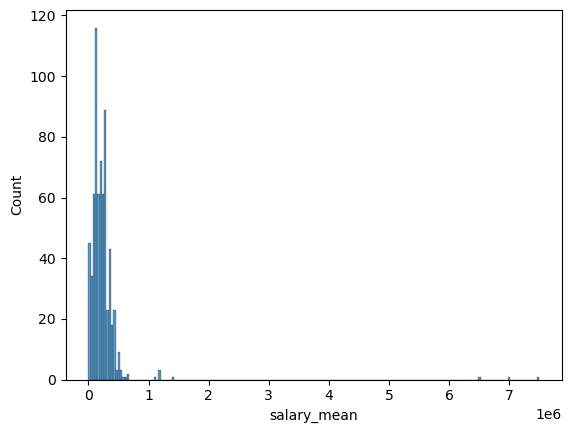

In [9]:
sns.histplot(df_tg["salary_mean"])
plt.show()

Присутсвуют выбрсы, либо по 2.5 процента срезать по кроям, либо логарифмировать таргетную переменную

In [15]:
thr_l, thr_r = np.percentile(df_tg.salary_mean, [5, 95])
df = df_tg[(df_tg.salary_mean > thr_l) & (df_tg.salary_mean < thr_r)]

c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


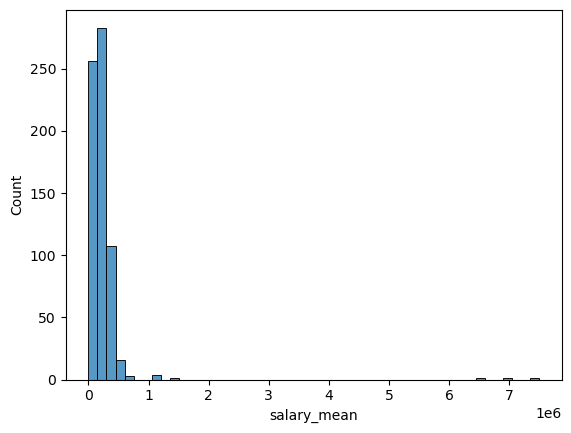

In [16]:
sns.histplot(df_tg["salary_mean"], bins= 50)
plt.show()

Смотрим распределение зп по квалификации.

c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='salary_mean', ylabel='qualification'>

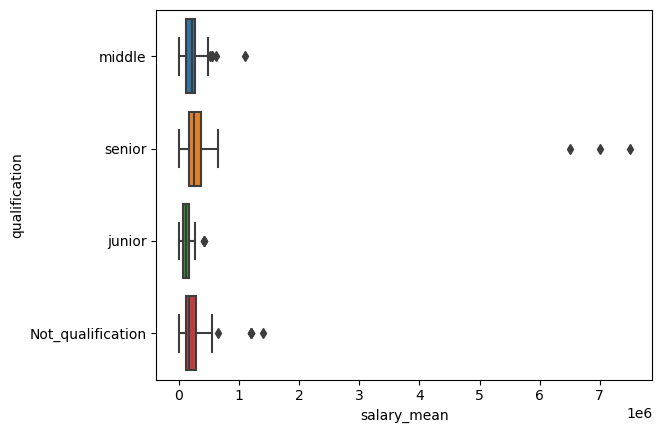

In [14]:
sns.boxplot(data=df_tg, x="salary_mean", y="qualification")

Группируем по уровням квалификации, регионам

c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='qualification', ylabel='Count'>

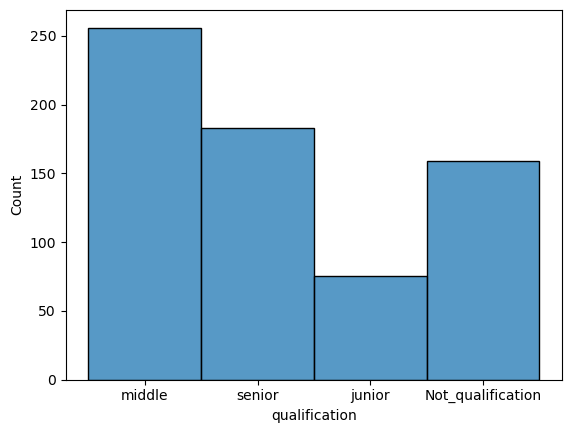

In [18]:
sns.histplot(df_tg["qualification"])

c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Andrew\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='location', ylabel='Count'>

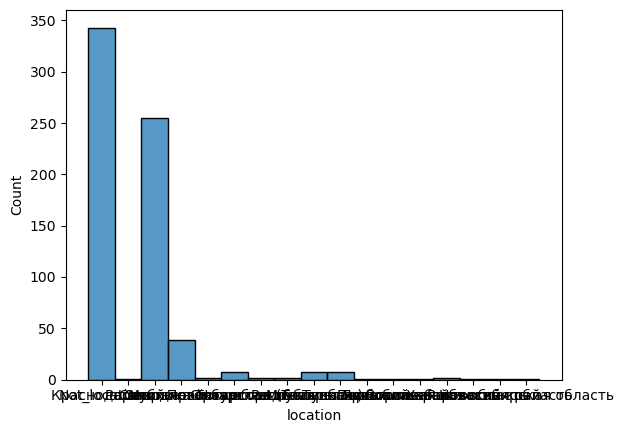

In [19]:
sns.histplot(df_tg["location"])

Везде наблюдаем разбаоансировку групп. Возможно надо оценить какое количество пападает в каждую группу и группы где менее 10 вакансий удалить  
Так же необходимо собрать дополнительно данных. Новые данные будут взят с сайта "труд всем" и проведен аналогичная предобработка.

Из моделей планирую использовать catboost, который хорошо умеет работать с категориальными признаками.

In [20]:
df_tg.columns

Index(['name_job', 'type_busy', 'qualification', 'location',
       'federalDistrictCode', 'skills', 'salary_min', 'salary_max',
       'salary_mean'],
      dtype='object')

Применим разбиение датасета и логарифмируем таргетную переменную

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_tg.drop(columns=["salary_mean", 'salary_min', 'salary_max']),
                                                    np.log(df_tg["salary_mean"]), 
                                                    train_size=0.8, 
                                                    random_state=42, shuffle=True)
cat_features =['name_job', 'type_busy', 'qualification', 'location',
       'federalDistrictCode', 'skills']

In [24]:
catboost = CatBoostRegressor(learning_rate=0.01, 
                                  has_time=True, 
                                  random_state=42, 
                                  iterations=800,
                                  cat_features=cat_features,
                                  custom_metric=['RMSE', 'MAE', 'R2'],
                                  depth=6)

catboost.fit(X_train, y_train, eval_set=(X_test, y_test), silent=True)
catboost.save_model('./catboost',format="cbm")

Для анализа работоспособности модели будут использоваться две основные метрики MAE и RMSE. Сравнение модеей будет происходить из расчета, чем меньше значение метрик тем лучше модель. Главной метрикой оценки результатов будет служить MAE, так как она менее чувствительна к выбросам. Планирую дальше использовать  catbost, но категориальные переменные буду преобразовывать сам и сравнивать с катбустом. Так же буду применять крос-валидацию по сетке для подбора лучших значений для модели, так как сейчас наблюдаем небольшое переобучение, особенно видно по параметру r2 и RMSE, но вот соотношение значений MAE можно было бы считать приемлемыми, поэтому оценку смотрю по нескольким критериям

In [25]:
print(catboost.get_best_score())

{'learn': {'MAE': 0.5484211616191141, 'R2': 0.4775007535913468, 'RMSE': 0.8864043792332182}, 'validation': {'MAE': 0.6575291727183962, 'R2': 0.146181095969399, 'RMSE': 1.160478590208751}}


Так же необходимо собрать дополнительные данные. Новые данные будут взяты с сайта "труд всем" и проведена аналогичная предобработка.  
 Данные обработки в другом ноутбуке в текущей директрии.